### Context:
The project focuses on fraud detection in a highly imbalanced dataset with over 6.3 million entries and 11 columns, of which only 8,213 entries are labeled as fraudulent. The dataset was divided into a training set of 4.4 million samples and a test set of 1.9 million samples, each containing 8 features. Given the extreme class imbalance, various machine learning models were tested, including Random Forest, LightGBM, Logistic Regression, XGBoost, and ensemble methods, to determine the model that best balances accuracy and sensitivity to fraud cases.

### Content:
- **Exploratory Data Analysis (EDA):** The analysis began with a review of the dataset's structure, class distribution, and feature types. Preprocessing included label encoding for categorical variables, as no standardization or normalization was necessary for this set of models. Additionally, there were no missing values to handle.

- **Modeling and Evaluation:** Multiple models were trained and evaluated using metrics suitable for imbalanced data, such as Accuracy, Precision,          Recall, F1-Score, and Area Under the Precision-Recall Curve (AUPRC). Emphasis was placed on Recall and AUPRC to ensure models could accurately          detect fraud cases while not being overly influenced by the majority class.

- **Model Results:**

  - **Random Forest:** Achieved high accuracy (0.9997) with a balanced precision (0.9774) and recall (0.7828), resulting in an AUPRC score of 0.7654.         While biased slightly toward the majority class, Random Forest provided reasonable fraud detection capabilities.
  - **LightGBM:** Emphasized recall, achieving 0.9762, though with lower precision at 0.6200 and an AUPRC of 0.6052.
  - **Logistic Regression:** Showed high recall (0.8674) but extremely low precision (0.0302), leading to a very low AUPRC of 0.0263. This indicated          Logistic Regression struggled significantly in handling the class imbalance.
  - **XGBoost:** Achieved similar results to LightGBM, with high recall (0.9766), but lower precision (0.5514) and AUPRC (0.5385).
  - **Ensemble Models (Using XGBoost and LightGBM):** Both soft and hard voting ensemble methods were applied using XGBoost and LightGBM models:
  - **Soft Voting:** Achieved a strong recall (0.9807) and AUPRC of 0.5736, indicating average performance in detecting fraud cases.
  - **Hard Voting:** Improved over soft voting, with a recall of 0.9569 and a higher AUPRC of 0.6808.
  - **Custom Ensemble (Best Performance):** The custom ensemble model, combining XGBoost and LightGBM, produced the highest results with an accuracy of       0.9997, precision of 0.8569, recall of 0.9343, F1-score of 0.8939, and AUPRC of 0.8007. This model demonstrated excellent capability in detecting       fraud cases while maintaining strong precision.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier

In [2]:
# Read Dataset
df = pd.read_csv("C:/Users/sahil/Downloads/ML-Models/Fraud.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**Data Optimization (Memory Reduction)**

In [5]:
# Convert specified columns to appropriate dtypes to reduce memory usage
df[['isFraud', 'isFlaggedFraud']] = df[['isFraud', 'isFlaggedFraud']].astype('int8')
df['step'] = df['step'].astype('int16')

# Define the columns to be converted
columns_to_convert = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
# Convert the specified columns to float32
df[columns_to_convert] = df[columns_to_convert].astype('float32')

In [6]:
# 3. Basic Data Summary
print("Data Summary:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int16  
 1   type            object 
 2   amount          float32
 3   nameOrig        object 
 4   oldbalanceOrg   float32
 5   newbalanceOrig  float32
 6   nameDest        object 
 7   oldbalanceDest  float32
 8   newbalanceDest  float32
 9   isFraud         int8   
 10  isFlaggedFraud  int8   
dtypes: float32(5), int16(1), int8(2), object(3)
memory usage: 291.3+ MB
None

Basic Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338834e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888242e+06    2.924048e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.00000

In [7]:
print(df.isFraud.value_counts())
print(df.isFlaggedFraud.value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


**Exploratory Data Analysis (EDA)**

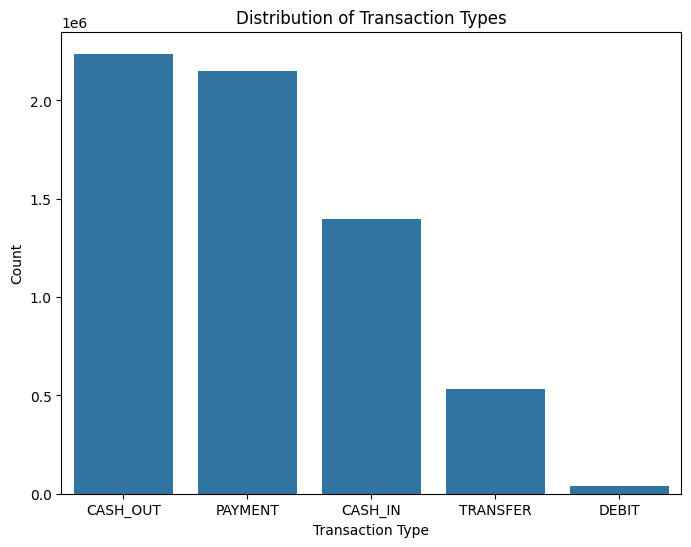

In [8]:
# Distribution of Transaction Types
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title("Distribution of Transaction Types")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

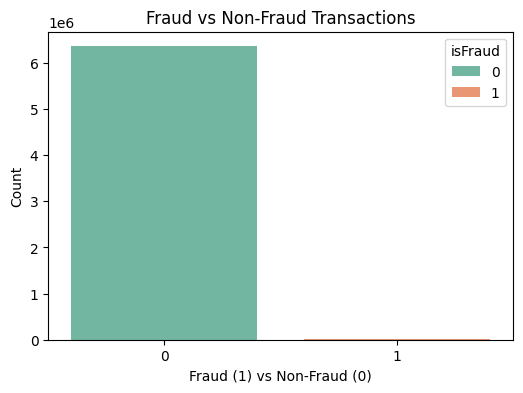

Fraudulent transactions: 0.13%


In [9]:
# Fraud Frequency
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='isFraud', palette='Set2', hue='isFraud')
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Fraud (1) vs Non-Fraud (0)")
plt.ylabel("Count")
plt.show()
fraud_rate = df['isFraud'].mean() * 100
print(f"Fraudulent transactions: {fraud_rate:.2f}%")

Flagged transactions labeled as fraud vs non-fraud:
 isFraud
1    16
Name: count, dtype: int64


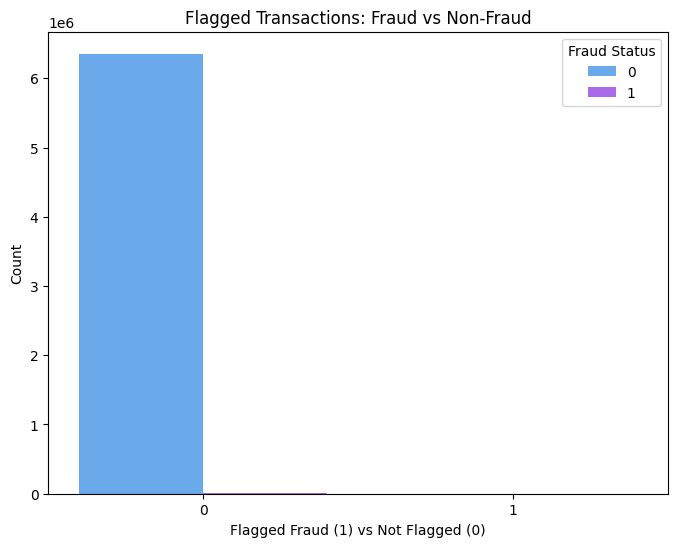

In [10]:
# Flagged Transactions Analysis
flagged_fraud_count = df[df['isFlaggedFraud'] == 1]['isFraud'].value_counts()
print("Flagged transactions labeled as fraud vs non-fraud:\n", flagged_fraud_count)

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='isFlaggedFraud', hue='isFraud', palette='cool')
plt.title("Flagged Transactions: Fraud vs Non-Fraud")
plt.xlabel("Flagged Fraud (1) vs Not Flagged (0)")
plt.ylabel("Count")
plt.legend(title="Fraud Status")
plt.show()

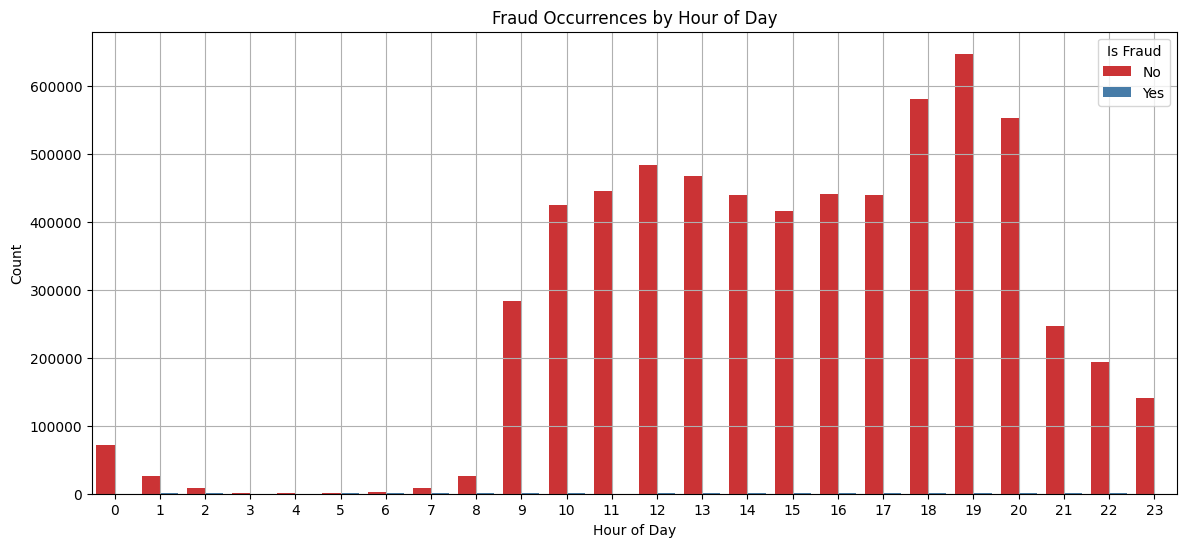

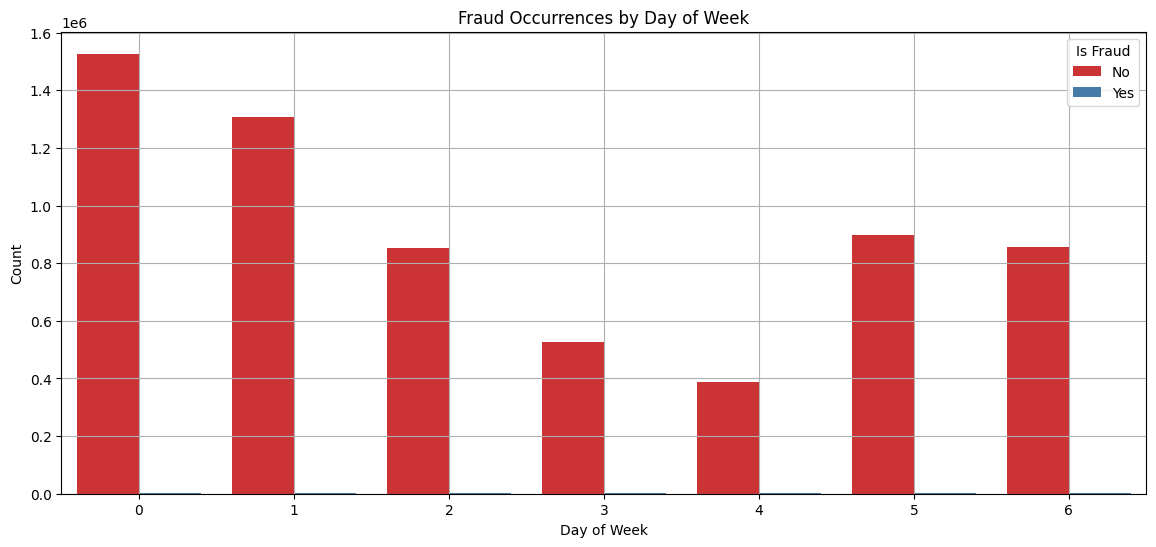

In [11]:
credit2 = df.copy()

# Create new features: hour of the day and day of the week
credit2['hour_of_day'] = credit2['step'] % 24  # 0-23 for each hour
credit2['day_of_week'] = (credit2['step'] // 24) % 7  # 0-6 for each day

# Visualizing hourly transaction counts
plt.figure(figsize=(14, 6))
sns.countplot(data=credit2, x='hour_of_day', hue='isFraud', palette='Set1')
plt.title('Fraud Occurrences by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title='Is Fraud', loc='upper right', labels=['No', 'Yes'])
plt.grid()
plt.show()

# Visualizing daily transaction counts
plt.figure(figsize=(14, 6))
sns.countplot(data=credit2, x='day_of_week', hue='isFraud', palette='Set1')
plt.title('Fraud Occurrences by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Is Fraud', loc='upper right', labels=['No', 'Yes'])
plt.grid()
plt.show()

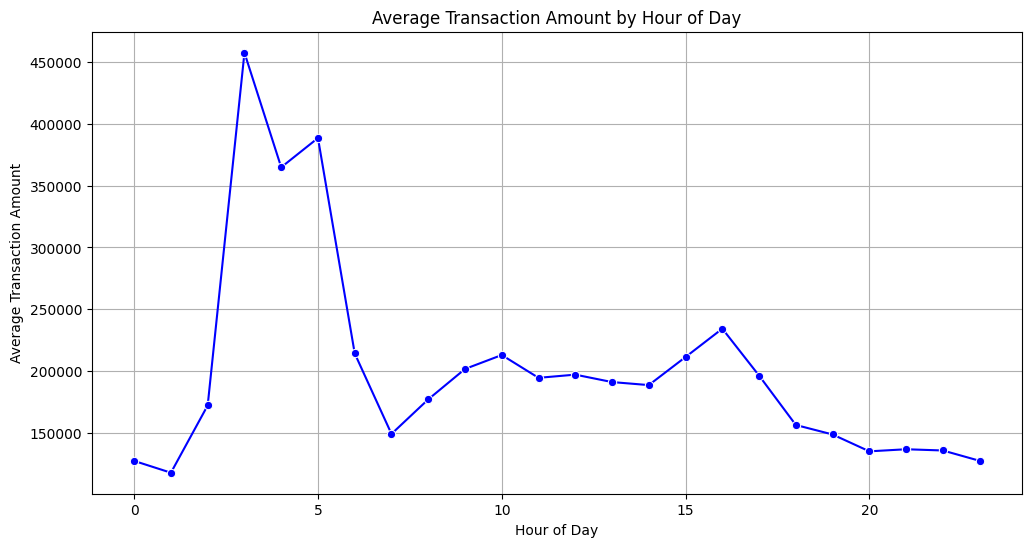

In [12]:
# Average transaction amount by hour of day
hourly_amount = credit2.groupby('hour_of_day')['amount'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_amount.index, y=hourly_amount.values, marker="o", color='blue')
plt.title('Average Transaction Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Transaction Amount')
plt.grid()
plt.show()

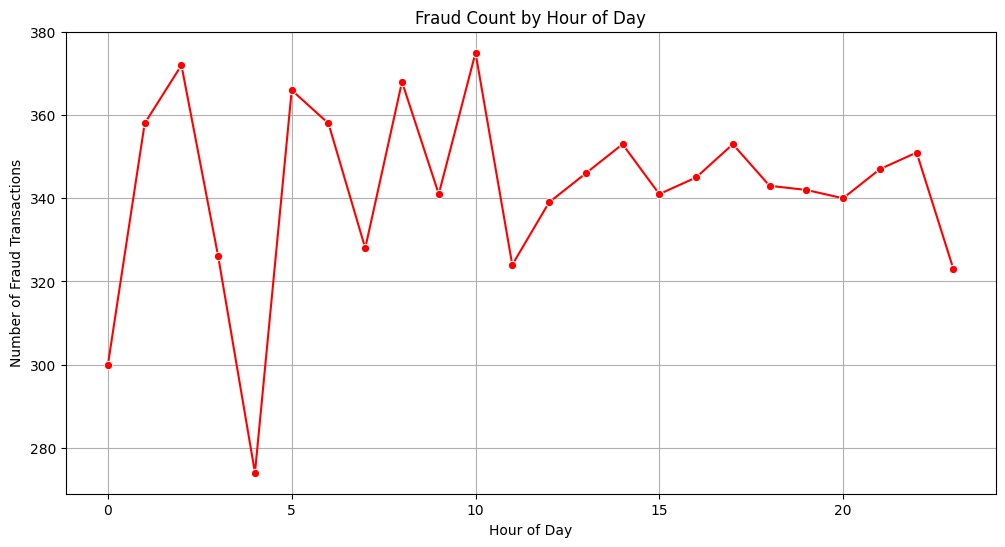

In [13]:
# Fraud occurrences by hour of day
hourly_fraud = credit2[credit2['isFraud'] == 1].groupby('hour_of_day').size()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_fraud.index, y=hourly_fraud.values, marker="o", color='red')
plt.title('Fraud Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraud Transactions')
plt.grid()
plt.show()

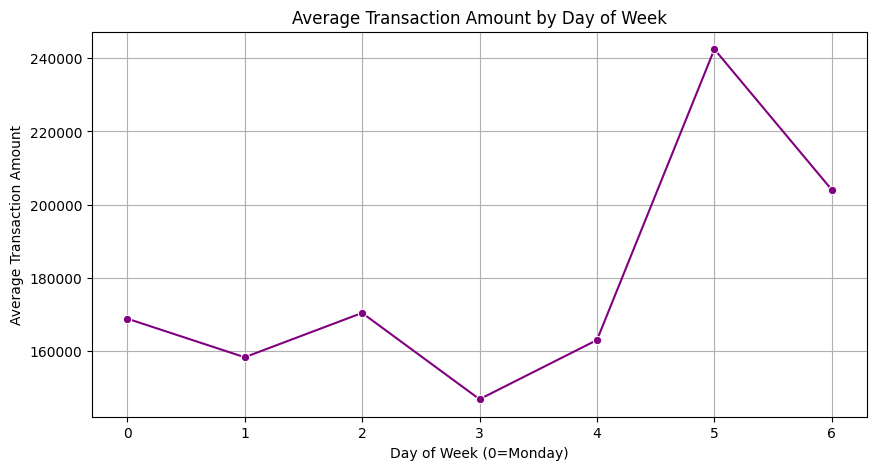

In [14]:
# Average transaction amount by day of the week
weekly_amount = credit2.groupby('day_of_week')['amount'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=weekly_amount.index, y=weekly_amount.values, marker="o", color='purple')
plt.title('Average Transaction Amount by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Transaction Amount')
plt.grid()
plt.show()

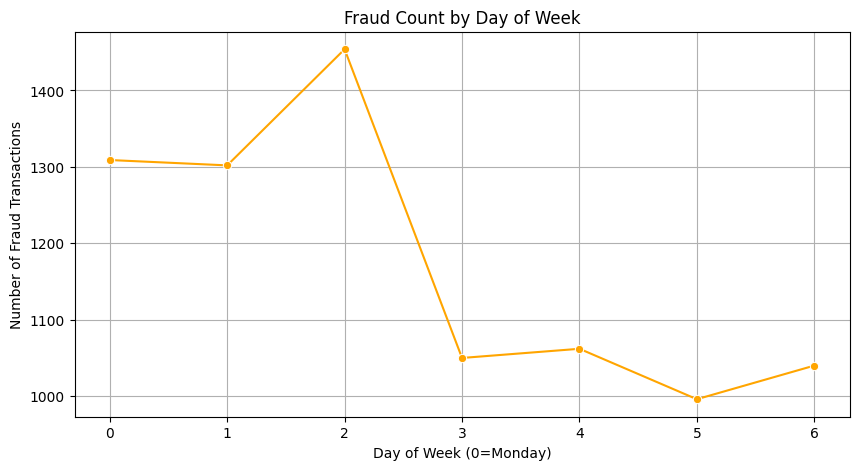

In [15]:
# Fraud occurrences by day of the week
weekly_fraud = credit2[credit2['isFraud'] == 1].groupby('day_of_week').size()

plt.figure(figsize=(10, 5))
sns.lineplot(x=weekly_fraud.index, y=weekly_fraud.values, marker="o", color='orange')
plt.title('Fraud Count by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Number of Fraud Transactions')
plt.grid()
plt.show()

**Feature Selection**

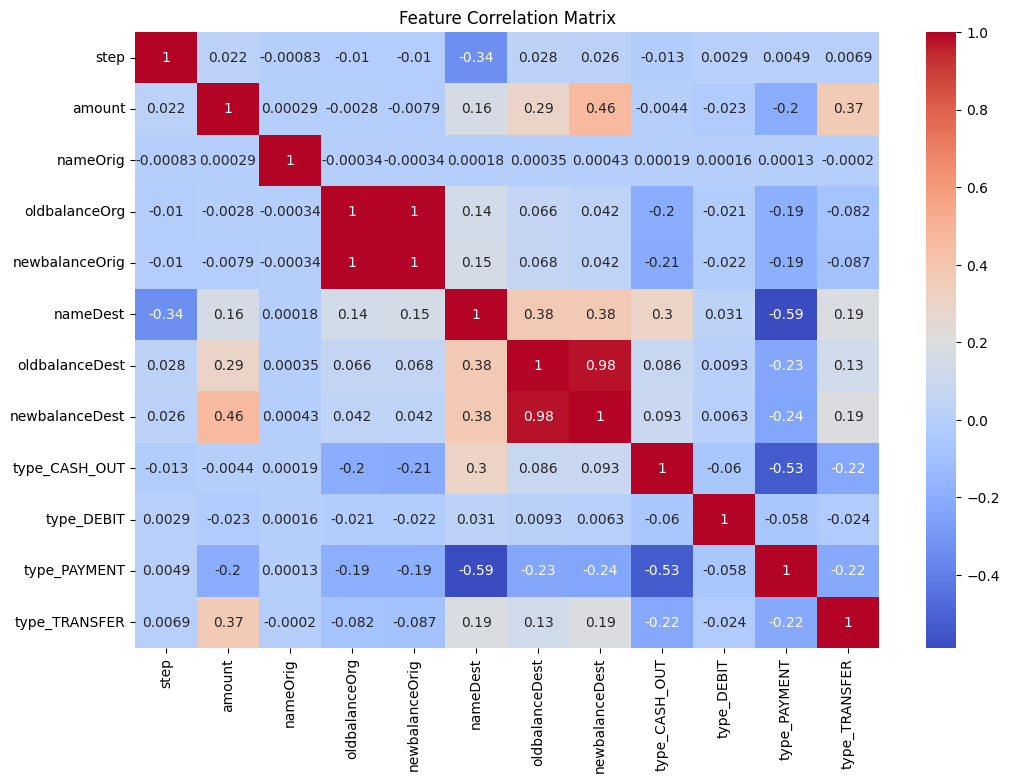

In [16]:
# 1. Split Data into X and y
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])  # Drop target and any leakage columns
y = df['isFraud']

# 1. Convert Low-Cardinality Categorical Variables with One-Hot Encoding
# Limit one-hot encoding to categorical columns with fewer than 10 unique values
low_cardinality_cols = [col for col in X.select_dtypes(include=['object']).columns if X[col].nunique() < 10]
X = pd.get_dummies(X, columns=low_cardinality_cols, drop_first=True)

# 2. Apply Frequency Encoding to High-Cardinality Columns
high_cardinality_cols = [col for col in X.select_dtypes(include=['object']).columns if X[col].nunique() >= 10]
for col in high_cardinality_cols:
    freq_encoding = X[col].value_counts(normalize=True)
    X[col] = X[col].map(freq_encoding)

# 2. Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", annot=True)
plt.title("Feature Correlation Matrix")
plt.show()

C:\Users\sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(


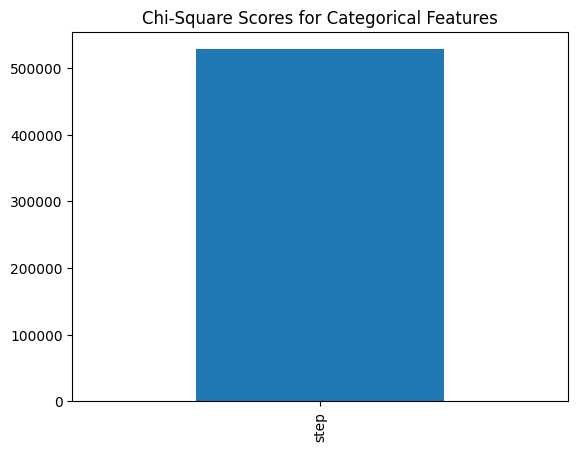

In [17]:
# 3. Chi-Square and Mutual Information Feature Selection on Encoded Data

# Separate categorical and continuous columns
categorical_features = X.select_dtypes(include=['int', 'int8', 'int16']).columns
continuous_features = X.select_dtypes(include=['float', 'float32']).columns

# Chi-square test for categorical features
chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X[categorical_features], y)
chi2_scores = pd.Series(chi2_selector.scores_, index=categorical_features)

# Plot Chi-square
chi2_scores.sort_values(ascending=False).plot(kind='bar', title="Chi-Square Scores for Categorical Features")
plt.show()

**Preprocessing**

In [18]:
# make a copy of df
data = df.copy()

# Drop 'nameOrig' and 'nameDest' (or you can encode them)
data = data.drop(['nameOrig', 'nameDest'], axis=1)

# Label encode the 'type' column
data['type'] = LabelEncoder().fit_transform(data['type'])

# Train-Test Split
X = data.drop(columns=['isFraud'])
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (4453834, 8), Test shape: (1908786, 8)


**ML Models**

In [25]:
# Random Forest

# Initialize Random Forest model
rfc_model = RandomForestClassifier()

# Fit the model to training data
rfc_model.fit(X_train, y_train)

# Make predictions
y_pred_rfc = rfc_model.predict(X_test)

# Calculate metrics
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc)
auprc_rfc = average_precision_score(y_test, y_pred_rfc)

# Print performance metrics
print("Random Forest Model Performance:")
print(f"Accuracy: {accuracy_rfc:.4f}, Precision: {precision_rfc:.4f}, Recall: {recall_rfc:.4f}, F1-Score: {f1_rfc:.4f}")
print(f"AVG Precision Score (AUPRC): {auprc_rfc:.4f}")

# confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfc))

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rfc))

Random Forest Model Performance:
Accuracy: 0.9997, Precision: 0.9774, Recall: 0.7828, F1-Score: 0.8693
AVG Precision Score (AUPRC): 0.7654
Confusion Matrix:
 [[1906307      44]
 [    529    1906]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.78      0.87      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



In [20]:
# LightGBM

# Initialize the LightGBM model with class weight
lgb_model = LGBMClassifier(objective='binary', class_weight='balanced', random_state=42, num_leaves=140, verbosity=-1)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

# Calculate metrics
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)
auprc_lgb = average_precision_score(y_test, y_pred_lgb)

# Print performance metrics
print("LightGBM Model Performance:")
print(f"Accuracy: {accuracy_lgb:.4f}, Precision: {precision_lgb:.4f}, Recall: {recall_lgb:.4f}, F1-Score: {f1_lgb:.4f}")
print(f"AVG Precision Score (AUPRC): {auprc_lgb:.4f}")

# confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))

# Classification report
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

LightGBM Model Performance:
Accuracy: 0.9992, Precision: 0.6200, Recall: 0.9762, F1-Score: 0.7583
AVG Precision Score (AUPRC): 0.6052
Confusion Matrix:
 [[1904894    1457]
 [     58    2377]]
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.62      0.98      0.76      2435

    accuracy                           1.00   1908786
   macro avg       0.81      0.99      0.88   1908786
weighted avg       1.00      1.00      1.00   1908786



In [19]:
# Logistic Regression 

# Initialize Logistic Regression with balanced class weight
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=5000)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auprc_lr = average_precision_score(y_test, y_pred_lr)

# Print performance metrics
print("Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy_lr:.4f}, Precision: {precision_lr:.4f}, Recall: {recall_lr:.4f}, F1-Score: {f1_lr:.4f}")
print(f"AVG Precision Score (AUPRC): {auprc_lr:.4f}")

# confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Model Performance:
Accuracy: 0.9643, Precision: 0.0302, Recall: 0.8674, F1-Score: 0.0583
AVG Precision Score (AUPRC): 0.0263
Confusion Matrix:
 [[1838456   67895]
 [    323    2112]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906351
           1       0.03      0.87      0.06      2435

    accuracy                           0.96   1908786
   macro avg       0.51      0.92      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786



In [21]:
# XGBoost 

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',  # Logarithmic loss function for binary classification
    use_label_encoder=False, # Avoids warning on deprecated encoder
    scale_pos_weight=540,  # Handles class imbalance
    max_depth=5, 
    n_estimators=200
)

# Fit the model to training data
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auprc_xgb = average_precision_score(y_test, y_pred_xgb)

# Print performance metrics
print("XGBoost Model Performance:")
print(f"Accuracy: {accuracy_xgb:.4f}, Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}, F1-Score: {f1_xgb:.4f}")
print(f"AVG Precision Score (AUPRC): {auprc_xgb:.4f}")


# confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Performance:
Accuracy: 0.9990, Precision: 0.5514, Recall: 0.9766, F1-Score: 0.7048
AVG Precision Score (AUPRC): 0.5385
Confusion Matrix:
 [[1904416    1935]
 [     57    2378]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.55      0.98      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.78      0.99      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786



In [22]:
# XGBoost and LightGBM Ensemble Model

# Initialize the base models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', n_estimators=195, max_depth=4,
                          scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])
                         )
lgbm_model = LGBMClassifier(objective='binary', class_weight='balanced', num_leaves=120, verbosity=-1, max_depth=15, boosting_type='goss',
                           n_estimators=280, min_data_in_leaf=100)

# Fit both models on the training data
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Generate predictions from both models
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]
lgbm_preds = lgbm_model.predict_proba(X_test)[:, 1]

# Stack the predictions
stacked_preds = np.column_stack((xgb_preds, lgbm_preds))

# Fit a meta-model (Logistic Regression)
meta_model = LogisticRegression()
meta_model.fit(stacked_preds, y_test)

# Make final predictions using the meta-model
final_preds = meta_model.predict(stacked_preds)

# Calculate metrics
accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)
auprc = average_precision_score(y_test, final_preds)

# Print performance metrics
print("Ensemble Model Performance:")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
print(f"AVG Precision Score (AUPRC): {auprc:.4f}")

# confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))

# Classification report
print("Ensemble Classification Report:")
print(classification_report(y_test, final_preds))

Ensemble Model Performance:
Accuracy: 0.9997, Precision: 0.8569, Recall: 0.9343, F1-Score: 0.8939
AVG Precision Score (AUPRC): 0.8007
Confusion Matrix:
 [[1905971     380]
 [    160    2275]]
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.86      0.93      0.89      2435

    accuracy                           1.00   1908786
   macro avg       0.93      0.97      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



In [23]:
# Voting ensemble with soft voting

# Initialize base models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', 
                          n_estimators=230, max_depth=4,
                          scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
lgbm_model = LGBMClassifier(objective='binary', class_weight='balanced', num_leaves=170, verbosity=-1)

# Create the Voting Classifier with soft voting
voting_ensemble_soft = VotingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='soft'  # Soft voting averages probabilities
)

# Fit the ensemble model
voting_ensemble_soft.fit(X_train, y_train)

# Generate predictions
soft_preds = voting_ensemble_soft.predict(X_test)

# Evaluate the model
soft_accuracy = accuracy_score(y_test, soft_preds)
soft_precision = precision_score(y_test, soft_preds)
soft_recall = recall_score(y_test, soft_preds)
soft_f1 = f1_score(y_test, soft_preds)
soft_auprc = average_precision_score(y_test, soft_preds)

print("Soft Voting Ensemble Model Performance:")
print(f"Accuracy: {soft_accuracy:.4f}, Precision: {soft_precision:.4f}, Recall: {soft_recall:.4f}, F1-Score: {soft_f1:.4f}")
print(f"AVG Precision Score (AUPRC): {soft_auprc:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, soft_preds))
print("\nClassification Report:\n", classification_report(y_test, soft_preds))

Soft Voting Ensemble Model Performance:
Accuracy: 0.9991, Precision: 0.5849, Recall: 0.9807, F1-Score: 0.7327
AVG Precision Score (AUPRC): 0.5736

Confusion Matrix:
 [[1904656    1695]
 [     47    2388]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.58      0.98      0.73      2435

    accuracy                           1.00   1908786
   macro avg       0.79      0.99      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786



In [24]:
# Voting ensemble with hard voting

# Initialize base models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', 
                          n_estimators=200, max_depth=4,
                          scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
lgbm_model = LGBMClassifier(objective='binary', class_weight='balanced', num_leaves=200, verbosity=-1)

# Create the Voting Classifier with hard voting
voting_ensemble_hard = VotingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='hard'  # Hard voting based on majority vote
)

# Fit the ensemble model
voting_ensemble_hard.fit(X_train, y_train)

# Generate predictions
hard_preds = voting_ensemble_hard.predict(X_test)

# Evaluate the model
hard_accuracy = accuracy_score(y_test, hard_preds)
hard_precision = precision_score(y_test, hard_preds)
hard_recall = recall_score(y_test, hard_preds)
hard_f1 = f1_score(y_test, hard_preds)
hard_auprc = average_precision_score(y_test, hard_preds)

print("Hard Voting Ensemble Model Performance:")
print(f"Accuracy: {hard_accuracy:.4f}, Precision: {hard_precision:.4f}, Recall: {hard_recall:.4f}, F1-Score: {hard_f1:.4f}")
print(f"AVG Precision Score (AUPRC): {hard_auprc:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, hard_preds))
print("\nClassification Report:\n", classification_report(y_test, hard_preds))

Hard Voting Ensemble Model Performance:
Accuracy: 0.9994, Precision: 0.7115, Recall: 0.9569, F1-Score: 0.8161
AVG Precision Score (AUPRC): 0.6808

Confusion Matrix:
 [[1905406     945]
 [    105    2330]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.71      0.96      0.82      2435

    accuracy                           1.00   1908786
   macro avg       0.86      0.98      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



### Conclusion:
The **custom ensemble model**, which combines the strengths of **XGBoost and LightGBM**, proved to be the most effective, achieving a high recall rate critical for fraud detection and a solid precision score. With an **AUPRC of 0.8007**, this model effectively prioritizes correct identification of fraud cases, making it suitable for real-world deployment where reducing false negatives is essential. Ensemble methods, particularly those using complementary models like XGBoost and LightGBM, offer a robust solution for imbalanced datasets by balancing recall and precision. Future steps could include fine-tuning hyperparameters and exploring additional ensemble configurations to further enhance model performance in fraud detection.